In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


In [3]:
file_path = "myData2.parquet"
df = pd.read_parquet(file_path)

In [34]:
selected_features = ['timestamp_seconds', 
                     'node_memory_Percpu_bytes', 
                     'node_context_switches_total', 
                     'surfsara_power_usage', 
                     'node_netstat_Tcp_InSegs', 
                     'node_netstat_Tcp_OutSegs', 
                     'node_network_transmit_packets_total-sum', 
                     'node_filesystem_size_bytes-sum', 
                     'node_filesystem_files-sum', 
                     'node_memory_MemFree_bytes', 
                     'node_netstat_Tcp_InErrs']
# FixMe

In [28]:
# selected_features = ['timestamp_seconds', 
#                      'node_memory_Percpu_bytes', 
#                      'node_context_switches_total', 
#                      'surfsara_power_usage', 
#                      'node_netstat_Tcp_InSegs', 
#                      'node_netstat_Tcp_OutSegs', 
#                      'node_network_transmit_packets_total-sum', 
#                      'node_filesystem_size_bytes-sum', 
#                      'node_filesystem_files-sum', 
#                      'node_memory_MemFree_bytes', 
#                      'node_netstat_Tcp_InErrs']


In [29]:
# Define time intervals
time_intervals = {'minute': '1T', 'hour': '1H', 'day': '1D'}

# Set sequence length
sequence_length = 30

# Number of time steps to predict into the future
prediction_steps = 7

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [30]:
# Function to prepare data for LSTM
def prepare_lstm_data(data, time_interval):
    data.set_index('timestamp', inplace=True)
    data_resampled = data.resample(time_interval).sum()
    
    target_mean = data_resampled['target'].mean()
    target_std = data_resampled['target'].std()
    data_resampled['target'] = (data_resampled['target'] - target_mean) / target_std
    
    target_min = data_resampled['target'].min()
    target_max = data_resampled['target'].max()
    print("Minimum value of target variable:", target_min)
    print("Maximum value of target variable:", target_max)
    
    return data_resampled


In [31]:
# Function to create sequences for LSTM
def create_lstm_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].values
        target = data.iloc[i+sequence_length]['target']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [32]:
# Function to make predictions on new data
def predict_future_failures(model, input_data, sequence_length, prediction_steps):
    predictions = []

    for _ in range(prediction_steps):
        # Make a prediction for the next time step
        prediction = model.predict(input_data.reshape(1, sequence_length, input_data.shape[1]))
        predictions.append(prediction[0, 0])

        # Shift the input data by one time step and append the new prediction
        input_data = np.roll(input_data, shift=-1, axis=0)
        input_data[-1, -1] = prediction[0, 0]

    return predictions


# 30 days -> 7 days

In [35]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [36]:
#DeleteMe
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])
#DeleteMe

# Prepare data for LSTM with daily intervals
lstm_data_day = prepare_lstm_data(df_selected, time_intervals['day'])

# Create sequences and targets
sequences_day, targets_day = create_lstm_sequences(lstm_data_day, sequence_length)

# Define the index to split the data
split_index_day = int(len(sequences_day) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_day, X_test_day = sequences_day[:split_index_day], sequences_day[split_index_day:]
y_train_day, y_test_day = targets_day[:split_index_day], targets_day[split_index_day:]

# Build the LSTM model
lstm_model_day = Sequential()
lstm_model_day.add(LSTM(1, input_shape=(X_train_day.shape[1], X_train_day.shape[2])))
lstm_model_day.add(Dense(1, activation='sigmoid')) # FixMe
optimizer = Adam(learning_rate=0.0005)
lstm_model_day.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

# Train the model
history_day = lstm_model_day.fit(X_train_day, y_train_day, epochs=20, batch_size=32, validation_split=0.1)

#DeleteMe
# Evaluate the model using Mean Squared Error
mse_day = lstm_model_day.evaluate(X_test_day, y_test_day, verbose=0)[1]
print(f'Model Mean Squared Error: {mse_day:.4f}\n')

# Evaluate model on test data
y_pred_day = lstm_model_day.predict(X_test_day)

# Calculate Root Mean Squared Error
rmse = mean_squared_error(y_test_day, y_pred_day, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_day, y_pred_day)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared
r2 = r2_score(y_test_day, y_pred_day)
print("R-squared (R2):", r2)

# Additional: Compare with training and validation loss from history
train_loss = history_day.history['loss']
val_loss = history_day.history['val_loss']


Minimum value of target variable: -0.7362924419461765
Maximum value of target variable: 5.322951443655186
Epoch 1/20
2/2 [==============================] - 2s 481ms/step - loss: 1.0379 - mean_squared_error: 1.0379 - val_loss: 1.2345 - val_mean_squared_error: 1.2345
Epoch 2/20
2/2 [==============================] - 0s 60ms/step - loss: 1.0376 - mean_squared_error: 1.0376 - val_loss: 1.2339 - val_mean_squared_error: 1.2339
Epoch 3/20
2/2 [==============================] - 0s 64ms/step - loss: 1.0373 - mean_squared_error: 1.0373 - val_loss: 1.2334 - val_mean_squared_error: 1.2334
Epoch 4/20
2/2 [==============================] - 0s 61ms/step - loss: 1.0370 - mean_squared_error: 1.0370 - val_loss: 1.2328 - val_mean_squared_error: 1.2328
Epoch 5/20
2/2 [==============================] - 0s 60ms/step - loss: 1.0368 - mean_squared_error: 1.0368 - val_loss: 1.2323 - val_mean_squared_error: 1.2323
Epoch 6/20
2/2 [==============================] - 0s 66ms/step - loss: 1.0365 - mean_squared_error

## Performance_Day

In [11]:
# Evaluate the model using Mean Squared Error
mse_day = lstm_model_day.evaluate(X_test_day, y_test_day, verbose=0)[1]
print(f'Mean Squared Error: {mse_day:.4f}\n')


Model Mean Squared Error: 2.1283



In [12]:
# Evaluate model on test data
y_pred_day = lstm_model_day.predict(X_test_day)

# Calculate Mean Absolute Error
mae_day = mean_absolute_error(y_test_day, y_pred_day)
print(f'Mean Abosolute Error: {mae_day:.4f}\n')

# Calculate Root Mean Squared Error
rmse_day = mean_squared_error(y_test_day, y_pred_day, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_day:.4f}\n')

# Calculate R-squared
r2_day = r2_score(y_test_day, y_pred_day)
print(f'R-squared (R2): {r2_day:.4f}\n')


1/1 [==============================] - 0s 493ms/step
Mean Absolute Error (MAE): 1.0572896575432653
Root Mean Squared Error (RMSE): 1.4588564677079516
R-squared (R2): -0.027238456764606678


### Training and Validation Loss Plot

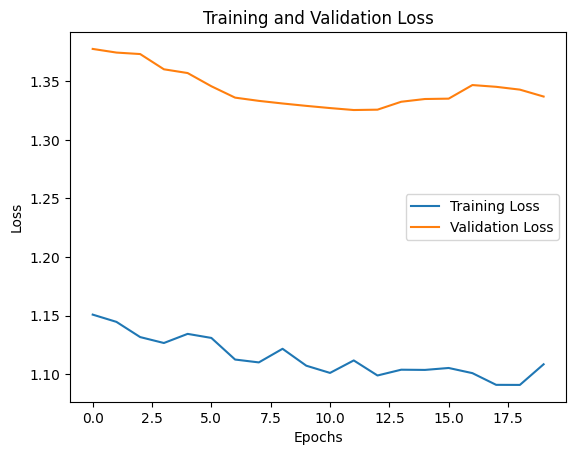

In [242]:
# Plot training and validation loss
plt.plot(history_day.history['loss'], label='Training Loss')
plt.plot(history_day.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

1/1 [==============================] - 0s 20ms/step
Predicted failures for the next 7 days:
[2.8893077 2.975282  2.9989657 3.002221  3.06272   3.5429153 3.5399103]

Mean Squared Error for Predictions: 0.6950

Mean Absolute Error for Predictions: 0.6703


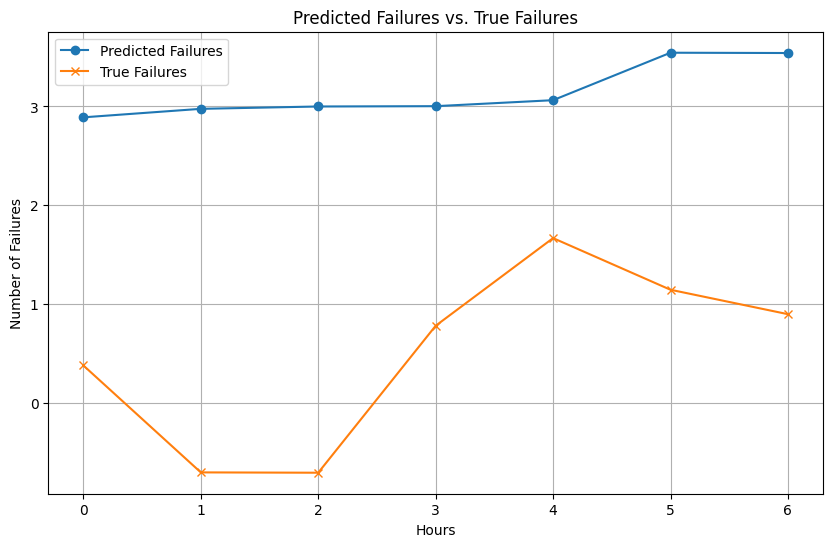

In [243]:
index_day = 14  # Can be any valid starting point

input_data_day = X_test_day[index_day]

# Make predictions
predicted_failures_day = predict_future_failures(lstm_model_day, input_data_day, sequence_length, prediction_steps)

# Denormalize the predicted failures 
predicted_failures_denormalized_day = np.array(predicted_failures_day) * (lstm_data_day['target'].max() - lstm_data_day['target'].min()) + lstm_data_day['target'].min()

# Get the true failures for the specified number of hours
true_failures_day = y_test_day[index_day:index_day + prediction_steps]  # Adjust the range as needed

# Print the predicted failures
print("Predicted failures for the next 7 days:")
print(predicted_failures_denormalized_day)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_day - true_failures_day)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_day - true_failures_day))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_denormalized_day, label='Predicted Failures', marker='o')
plt.plot(true_failures_day, label='True Failures', marker='x')
plt.xlabel('Hours')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()


# 30 hours -> 7 hours

In [244]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [245]:
# Prepare data for LSTM with hourly intervals
lstm_data_hour = prepare_lstm_data(df_selected, time_intervals['hour'])

# Create sequences and targets
sequences_hour, targets_hour = create_lstm_sequences(lstm_data_hour, sequence_length)

# Define the index to split the data
split_index_hour = int(len(sequences_hour) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_hour, X_test_hour = sequences_hour[:split_index_hour], sequences_hour[split_index_hour:]
y_train_hour, y_test_hour = targets_hour[:split_index_hour], targets_hour[split_index_hour:]

# Build the LSTM model
lstm_model_hour = Sequential()
lstm_model_hour.add(LSTM(20, input_shape=(X_train_hour.shape[1], X_train_hour.shape[2])))
lstm_model_hour.add(Dense(1, activation='sigmoid'))
lstm_model_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
history_hour = lstm_model_hour.fit(X_train_hour, y_train_hour, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/20
54/54 [==============================] - 3s 29ms/step - loss: 0.4547 - mean_squared_error: 0.4547 - val_loss: 0.3933 - val_mean_squared_error: 0.3933
Epoch 2/20
54/54 [==============================] - 1s 22ms/step - loss: 0.2979 - mean_squared_error: 0.2979 - val_loss: 0.3190 - val_mean_squared_error: 0.3190
Epoch 3/20
54/54 [==============================] - 1s 21ms/step - loss: 0.2570 - mean_squared_error: 0.2570 - val_loss: 0.2911 - val_mean_squared_error: 0.2911
Epoch 4/20
54/54 [==============================] - 1s 21ms/step - loss: 0.2438 - mean_squared_error: 0.2438 - val_loss: 0.2850 - val_mean_squared_error: 0.2850
Epoch 5/20
54/54 [==============================] - 1s 21ms/step - loss: 0.2399 - mean_squared_error: 0.2399 - val_loss: 0.2501 - val_mean_squared_error: 0.2501
Epoch 6/20
54/54 [==============================] - 1s 21ms/step - loss: 0.2362 - mean_squared_error: 0.2362 - val_loss: 0.2530 - val_mean_squared_error: 0.2530
Epoch 7/20
54/54 [================

## Performance_Hour

In [246]:
# Evaluate the model using Mean Squared Error
mse_hour = lstm_model_hour.evaluate(X_test_hour, y_test_hour, verbose=0)[1]
print(f'Model Mean Squared Error: {mse_hour:.4f}\n')

input_data = X_test_hour[3]  # Can be any valid starting point

# Make predictions
predicted_failures = predict_future_failures(lstm_model_hour, input_data, sequence_length, prediction_steps)

# Denormalize the predicted failures 
predicted_failures_denormalized = np.array(predicted_failures) * (lstm_data_hour['target'].max() - lstm_data_hour['target'].min()) + lstm_data_hour['target'].min()

# Print the predicted failures
print("Predicted Failures for the Next 7 Hours:")
print(predicted_failures_denormalized)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures - y_test_hour[3:3+prediction_steps])**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures - y_test_hour[3:3+prediction_steps]))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')



Model Mean Squared Error: 2.7371

1/1 [==============================] - 0s 20ms/step
Predicted Failures for the Next 7 Hours:
[0.529074   0.5801046  0.57865226 0.57741606 0.58144665 0.57575
 0.57498085]

Mean Squared Error for Predictions: 0.2347

Mean Absolute Error for Predictions: 0.4844


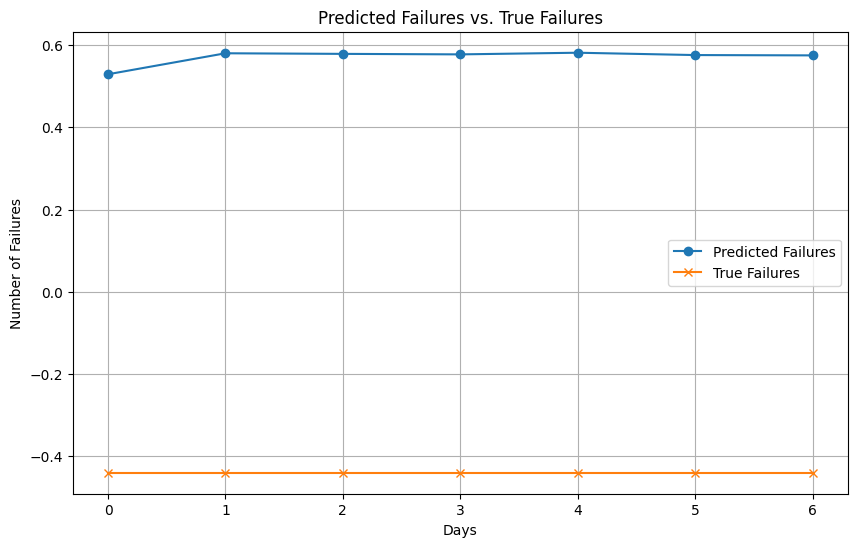

In [247]:
# Get the true failures for the specified number of days
true_failures = y_test_hour[2:2 + prediction_steps]  # Adjust the range as needed

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_denormalized, label='Predicted Failures', marker='o')
plt.plot(true_failures, label='True Failures', marker='x')
plt.xlabel('Days')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()

# 30 minutes -> 7 minutes - Overfitting

In [248]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [249]:
# Prepare data for LSTM with minute intervals
lstm_data_minute = prepare_lstm_data(df_selected, time_intervals['minute'])

# Create sequences and targets
sequences_minute, targets_minute = create_lstm_sequences(lstm_data_minute, sequence_length)

# Define the index to split the data
split_index_minute = int(len(sequences_minute) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_minute, X_test_minute = sequences_minute[:split_index_minute], sequences_minute[split_index_minute:]
y_train_minute, y_test_minute = targets_minute[:split_index_minute], targets_minute[split_index_minute:]

# Build the LSTM model
lstm_model_minute = Sequential()

# 50 -> 10
lstm_model_minute.add(LSTM(2, input_shape=(X_train_minute.shape[1], X_train_minute.shape[2])))
lstm_model_minute.add(Dense(1, activation='sigmoid'))
lstm_model_minute.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
lstm_model_minute.fit(X_train_minute, y_train_minute, epochs=5, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/5
3258/3258 [==============================] - 63s 19ms/step - loss: 0.2047 - mean_squared_error: 0.2047 - val_loss: 0.2013 - val_mean_squared_error: 0.2013
Epoch 2/5
3258/3258 [==============================] - 60s 18ms/step - loss: 0.1370 - mean_squared_error: 0.1370 - val_loss: 0.1893 - val_mean_squared_error: 0.1893
Epoch 3/5
3258/3258 [==============================] - 60s 18ms/step - loss: 0.1341 - mean_squared_error: 0.1341 - val_loss: 0.1884 - val_mean_squared_error: 0.1884
Epoch 4/5
3258/3258 [==============================] - 60s 18ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - val_loss: 0.1882 - val_mean_squared_error: 0.1882
Epoch 5/5
3258/3258 [==============================] - 60s 19ms/step - loss: 0.1334 - mean_squared_error: 0.1334 - val_loss: 0.1881 - val_mean_squared_error: 0.1881


In [250]:
# Evaluate the model using Mean Squared Error
mse_minute = lstm_model_minute.evaluate(X_test_minute, y_test_minute, verbose=0)[1]
print(f'Model Mean Squared Error: {mse_minute:.4f}\n')

input_data = X_test_minute[3]  # Can be any valid starting point

# Make predictions
predicted_failures = predict_future_failures(lstm_model_minute, input_data, sequence_length, prediction_steps)

# Denormalize the predicted failures
predicted_failures_denormalized = np.array(predicted_failures) * (lstm_data_minute['target'].max() - lstm_data_minute['target'].min()) + lstm_data_minute['target'].min()

# Print the predicted failures
print("Predicted failures for the next 7 minutes:")
print(predicted_failures_denormalized)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures - y_test_minute[3:3+prediction_steps])**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures - y_test_minute[3:3+prediction_steps]))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')


Model Mean Squared Error: 2.1625

1/1 [==============================] - 0s 20ms/step
Predicted failures for the next 7 minutes:
[-0.43427318 -0.43226475 -0.41830397 -0.3500804  -0.21468197 -0.10255602
 -0.04800594]

Mean Squared Error for Predictions: 0.1951

Mean Absolute Error for Predictions: 0.4416


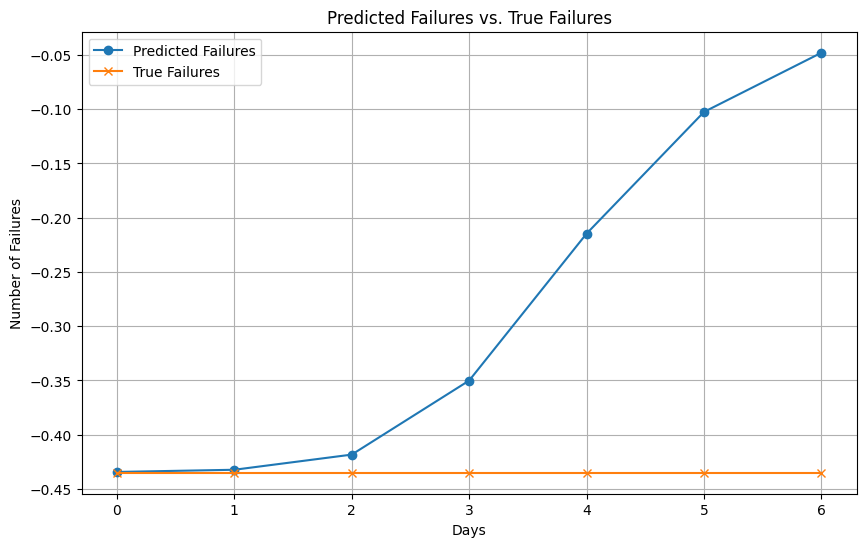

In [251]:
# Get the true failures for the specified number of days
true_failures = y_test_minute[2:2 + prediction_steps]  # Adjust the range as needed

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_denormalized, label='Predicted Failures', marker='o')
plt.plot(true_failures, label='True Failures', marker='x')
plt.xlabel('Days')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()